In [1]:
from utils import extract_from_mnist, visualize_data
from train import prep_data,create_model,training_loop,eval_test,eval_train, plot_losses,visualize_weights_and_signs
from adv_attack import adv_attack,create_adv_test
from RBF_architecture import ShallowRBF, RbfNet2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from torch.autograd import Variable


# 1\ RBF network

### Data Extraction

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

# Convert labels to integers
mnist.target = mnist.target.astype(int)

data = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
data['target'] = mnist.target

data = data.sample(n=20000, random_state=42)

# Reset the index of the filtered dataset
data = data.reset_index(drop=True)

# Print the shape of the filtered dataset
print("Filtered dataset shape:", data.shape)
print("Labels:", data['target'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/var/folders/91/hvhdt2vj68l460f4fv_t0k0h0000gn/T/ipykernel_85333/1308228047.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = mnist.target


Filtered dataset shape: (20000, 785)
Labels: 0        8
1        4
2        8
3        7
4        7
        ..
19995    8
19996    3
19997    1
19998    7
19999    6
Name: target, Length: 20000, dtype: int64


### Quick visualization

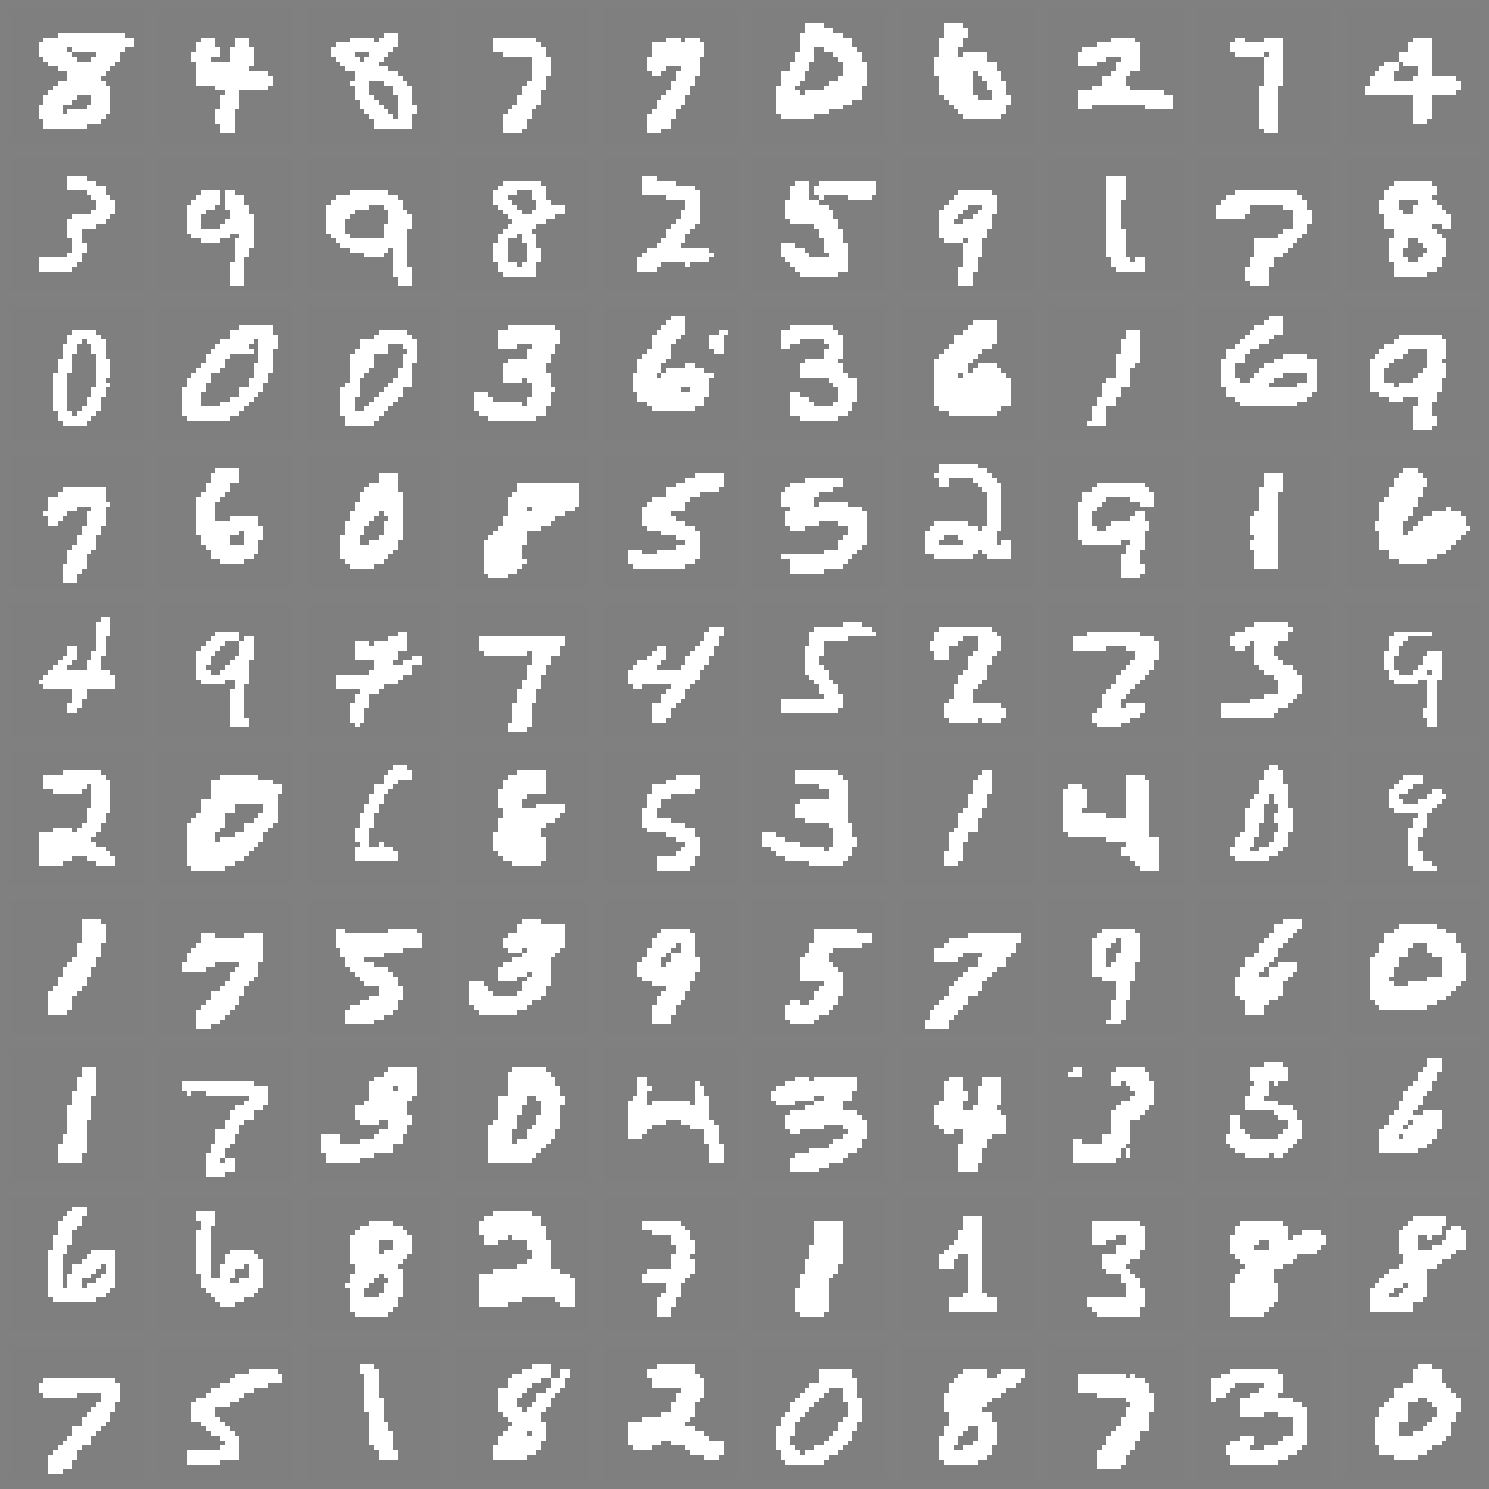

In [3]:
num_rows = 10
num_cols = 10
visualize_data(num_rows,num_cols, data) # to visualize the data

### Data preparation and model creation

In [4]:

# Assuming y is your target labels
y = data['target'].values

# Normalize the data
data_normalized = data.iloc[:, :-1].values / 255.0

# Convert data to PyTorch tensors
X_tensor = torch.tensor(data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
num_classes = len(set(y))
print("Unique classes in target labels:", num_classes)

Unique classes in target labels: 10


In [5]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, 64, shuffle=True)

In [23]:
# Hyperparameters
num_epochs = 200
learning_rate = 0.001
momentum = 0.9
Batch_size = 128
num_classes = 10
input_size = 784


In [24]:

batch_images,batch_labels= next(iter(train_loader))

centers = batch_images

input_size = X_train_tensor.shape[1]
model = RbfNet2(centers, num_class=10)
criterion = nn.CrossEntropyLoss()
sgd =  optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
adam = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = sgd
 

### Training Loop and performance 

In [28]:
training_loss ,model_trained = training_loop(optimizer, model, criterion, X_train_tensor, y_train_tensor,num_epochs=num_epochs,batch_size=Batch_size)
# to train the model

Epoch [1/200], Loss: 2.2898
Epoch [2/200], Loss: 2.2702
Epoch [3/200], Loss: 2.2700
Epoch [4/200], Loss: 2.2569
Epoch [5/200], Loss: 2.1936
Epoch [6/200], Loss: 2.1000
Epoch [7/200], Loss: 2.0157
Epoch [8/200], Loss: 2.0172
Epoch [9/200], Loss: 1.7952
Epoch [10/200], Loss: 1.8213
Epoch [11/200], Loss: 1.7350
Epoch [12/200], Loss: 1.6749
Epoch [13/200], Loss: 1.7818
Epoch [14/200], Loss: 1.6920
Epoch [15/200], Loss: 1.5540
Epoch [16/200], Loss: 1.7117
Epoch [17/200], Loss: 1.5613
Epoch [18/200], Loss: 1.7221
Epoch [19/200], Loss: 1.6341
Epoch [20/200], Loss: 1.5922
Epoch [21/200], Loss: 1.6390
Epoch [22/200], Loss: 1.7191
Epoch [23/200], Loss: 1.7557
Epoch [24/200], Loss: 1.6683
Epoch [25/200], Loss: 1.5918
Epoch [26/200], Loss: 1.4552
Epoch [27/200], Loss: 1.3678
Epoch [28/200], Loss: 1.4299
Epoch [29/200], Loss: 1.4185
Epoch [30/200], Loss: 1.4011
Epoch [31/200], Loss: 1.5156
Epoch [32/200], Loss: 1.4229
Epoch [33/200], Loss: 1.4739
Epoch [34/200], Loss: 1.5171
Epoch [35/200], Loss: 1

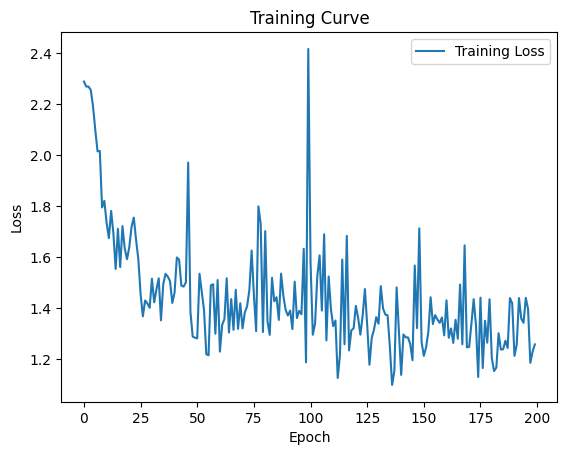

In [29]:
plot_losses(training_loss) # to plot the training loss

In [30]:
eval_train(X_train_tensor,y_train_tensor,model_trained) # to evaluate the model on the training set

Training Accuracy: 60.32%


### Weight Visualisation

In [25]:

visualize_weights_and_signs(model_trained) # to visualize the weights and signs of the model

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 640

# 2\ RBF Vs Adversarial

### Test set for original images

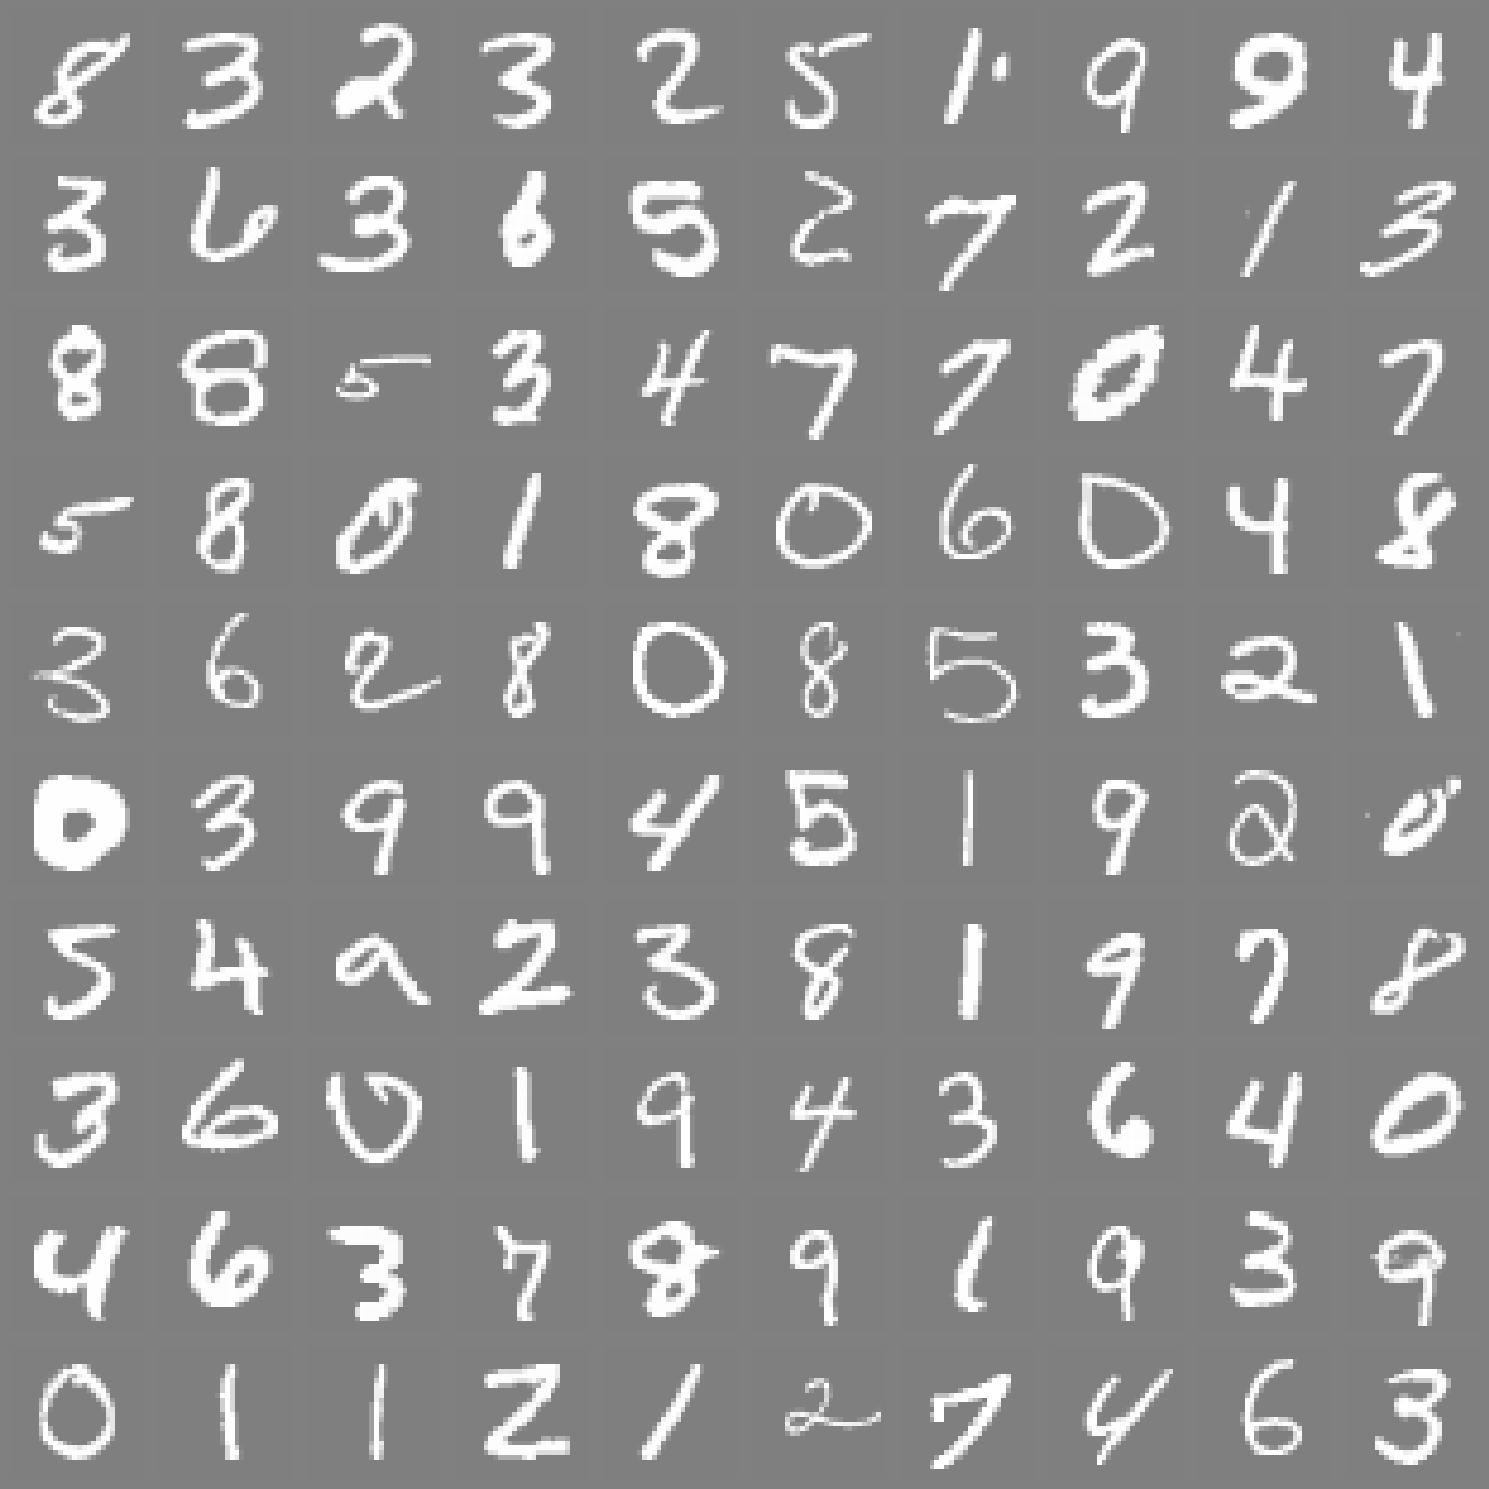

In [18]:

X_test_tensor2 = X_test_tensor.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor2) # to visualize the test data

### Evaluation of the model on the unaltered test set

In [31]:
eval_test(X_test_tensor,y_test_tensor,model)

Accuracy: 61.30%
Mean Confidence for All Examples: 0.4816
Mean Confidence for Incorrect Predictions: 0.3642


### Creation of the adversarial test set

In [26]:
eps = 0.25
X_test_tensor_adv = create_adv_test(model_trained,X_test_tensor,y_test_tensor,eps,criterion) # to create the adversarial test set

/Users/quentinrolland/Documents/GitHub/Adversarial_attack/RBF/adv_attack.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_im_norm =torch.tensor(alt_im, dtype=torch.float32)


### Visualization of the altered test set 

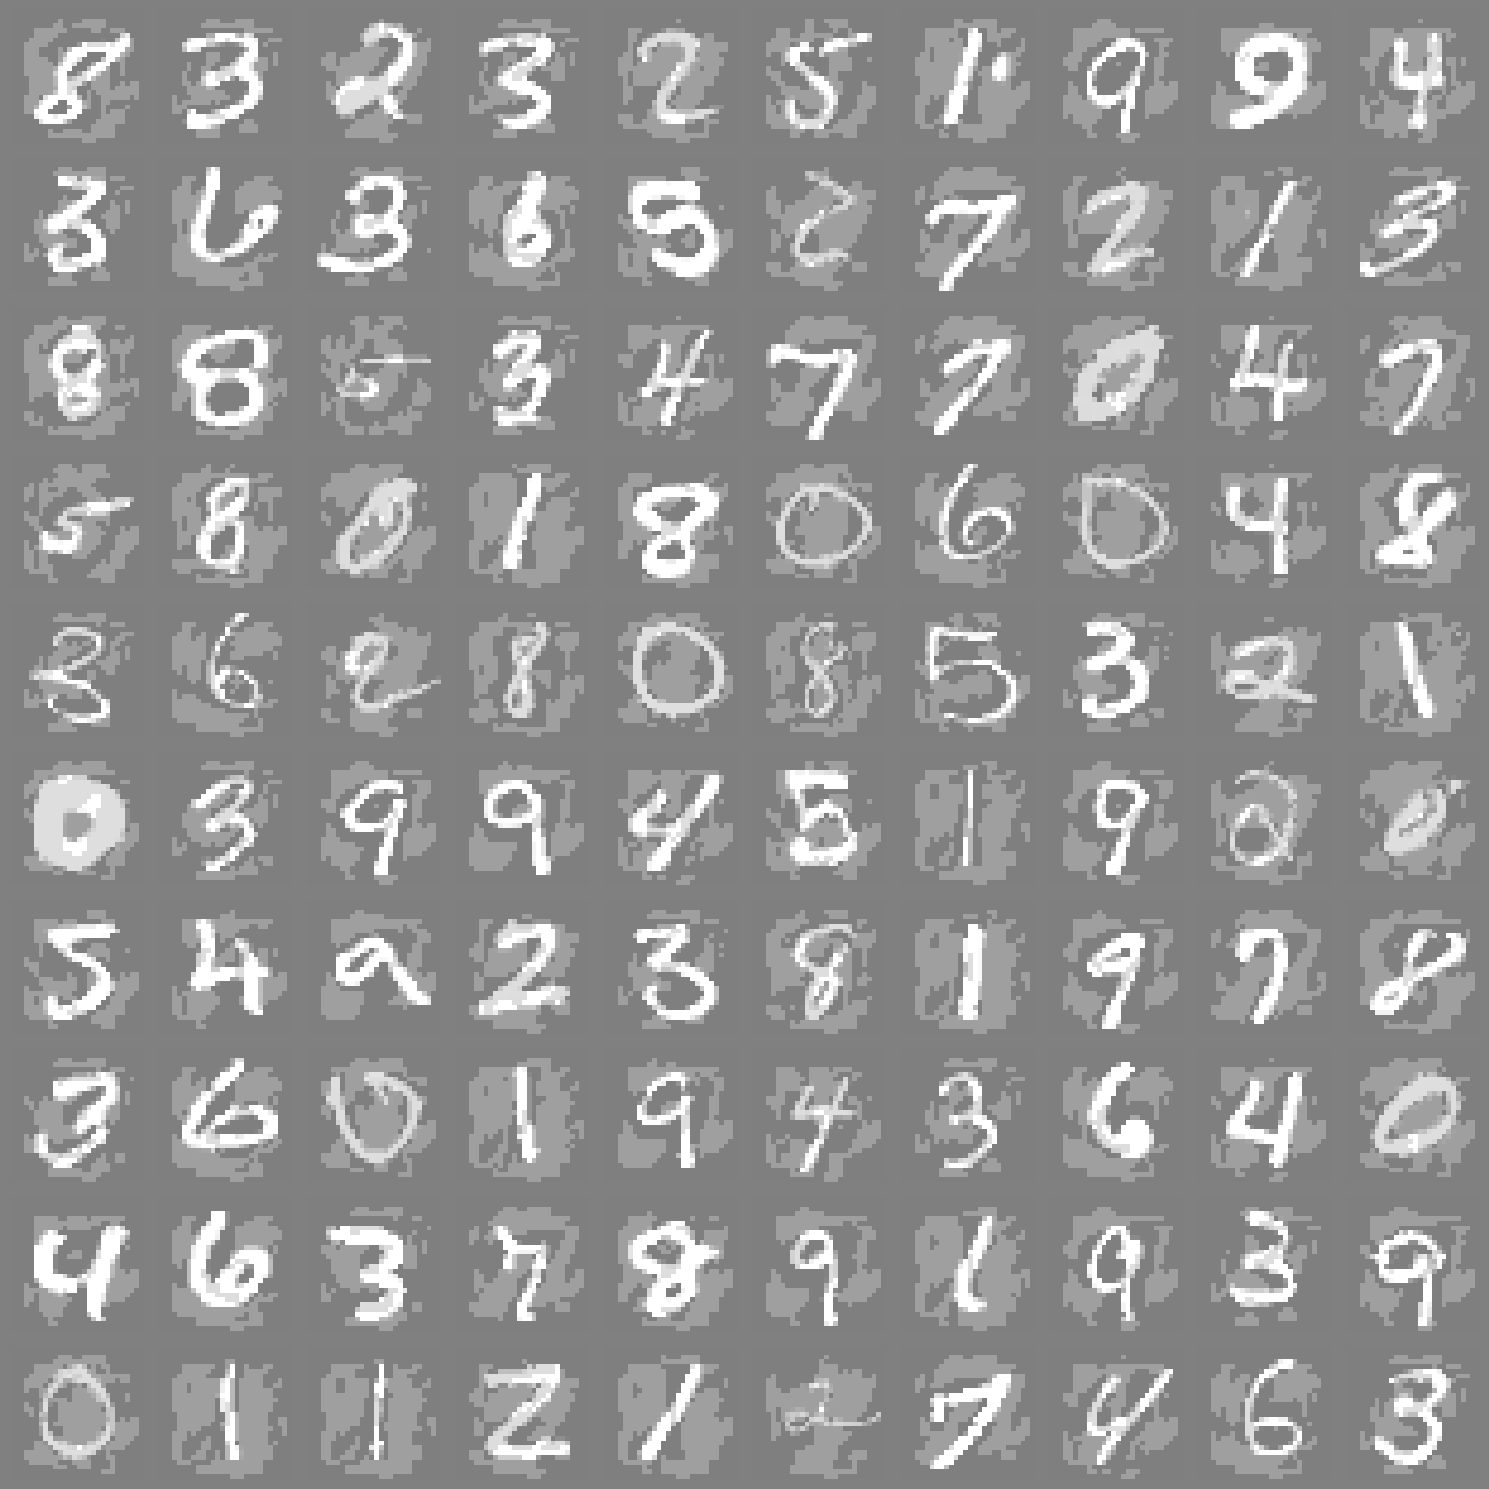

In [21]:
X_test_tensor_adv2 = X_test_tensor_adv.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor_adv2) # to visualize the adversarial test set

### Evaluation of the model on the altered test set 

In [32]:
eval_test(X_test_tensor_adv,y_test_tensor,model)

Accuracy: 21.73%
Mean Confidence for All Examples: 0.3428
Mean Confidence for Incorrect Predictions: 0.3350
